In [1]:
import folium
import pandas as pd

# 读取OD数据
od_data = pd.read_csv('data/20211001.csv', encoding='ISO-8859-1')

#取前1000条数据
od_data = od_data.head(1000)
# 创建地图对象，设置地图中心位置和缩放级别
m = folium.Map(location=[od_data['latStart'].mean(), od_data['lonStart'].mean()], zoom_start=12)

# 添加起点和终点标记
for index, row in od_data.iterrows():
    folium.Marker([row['latStart'], row['lonStart']], popup='Start').add_to(m)
    folium.Marker([row['latEnd'], row['lonEnd']], popup='End').add_to(m)

# 添加连线
for index, row in od_data.iterrows():
    folium.PolyLine(
        locations=[[row['latStart'], row['lonStart']], [row['latEnd'], row['lonEnd']]],
        color='blue',
        weight=2.5,
        opacity=1
    ).add_to(m)

# 显示地图
m

Mapping OD to Mesh: 100%|██████████| 1000/1000 [00:00<00:00, 16278.19it/s]


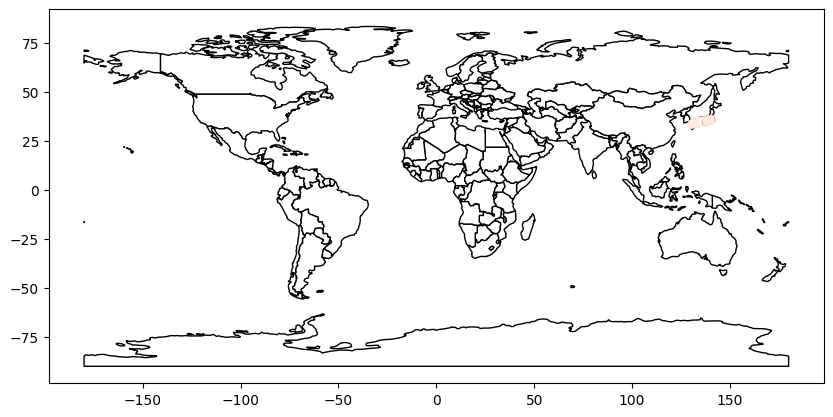

In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas.tools import geocode
from tqdm import tqdm

# 加载数据
data_path = 'data/20211001.csv'
df = pd.read_csv(data_path, nrows=1000,encoding='ISO-8859-1')
# 提取起始点和终点的经纬度
df['start_point'] = df.apply(lambda row: Point(row['lonStart'], row['latStart']), axis=1)
df['end_point'] = df.apply(lambda row: Point(row['lonEnd'], row['latEnd']), axis=1)
# 转换为 GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='start_point')

# 使用 tqdm 进度条遍历 GeoDataFrame
for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc='Mapping OD to Mesh'):
    # 检查起始点和终点是否存在空值
    if pd.isna(row['start_point']) or pd.isna(row['end_point']):
        continue
    # 提取起始点和终点的经纬度
    start_point = row['start_point']
    end_point = row['end_point']
    # 计算起始点和终点之间的距离，以米为单位
    distance = start_point.distance(end_point)
    # 根据距离计算流量，将流量值存储到 GeoDataFrame 中
    gdf.at[idx, 'flow'] = distance

# 将 GeoDataFrame 转换为以半径 5km 为网格的 GeoDataFrame
gdf['geometry'] = gdf['start_point'].buffer(5000)

# 绘制背景地图
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(10, 10))

# 绘制流量图
gdf.plot(column='flow', cmap='Reds', linewidth=gdf['flow'] / 1000, ax=ax)

# 显示流量图和背景地图
plt.show()


In [13]:
import folium
import pandas as pd

# 读取OD数据
od_data = pd.read_csv('data/20211001.csv', encoding='ISO-8859-1')

#取前1000条数据
od_data = od_data.head(1000)
# 创建地图对象，设置地图中心位置和缩放级别
m = folium.Map(location=[od_data['latStart'].mean(), od_data['lonStart'].mean()], zoom_start=12)

# 添加连线
for index, row in od_data.iterrows():
    folium.PolyLine(
        locations=[[row['latStart'], row['lonStart']], [row['latEnd'], row['lonEnd']]],
        color='blue',
        weight=2.5,
        opacity=1
    ).add_to(m)

# 显示地图
m


In [ ]:
import osmnx as ox
import folium
import pandas as pd
from tqdm import tqdm
# 读取OD数据
od_data = pd.read_csv('data/20211001.csv', encoding='ISO-8859-1')

# 取前1000条数据
od_data = od_data.head(1000)

# 获取地图中心位置
lat_center = od_data[['latStart', 'latEnd']].mean().mean()
lon_center = od_data[['lonStart', 'lonEnd']].mean().mean()

# 获取日本中国地区polygon
# place_name = 'Japan'
# polygon = ox.geocode_to_gdf(place_name).unary_union.convex_hull

polygon = ox.geometries_from_place('Japan', which_result=1,tags={'place':'country'})
# 获取高速公路路网
graph = ox.graph.graph_from_polygon(polygon, network_type='drive', simplify=True)



# 创建地图对象，设置地图中心位置和缩放级别
m = folium.Map(location=[lat_center, lon_center], zoom_start=12)

# 绘制路网
ox.plot_graph_folium(graph, graph_map=m, popup_attribute='name', edge_width=2, edge_color='blue')

# 添加OD线路
for index, row in tqdm(od_data.iterrows(), total=od_data.shape[0], desc='Adding OD routes'):   # Add tqdm to track progress
    # Project the graph
    graph_proj = ox.project_graph(graph)

    # Get nearest nodes
    start_node = ox.distance.nearest_nodes(graph_proj, row['lonStart'], row['latStart'])
    end_node = ox.distance.nearest_nodes(graph_proj, row['lonEnd'], row['latEnd'])
    print(start_node, end_node)

    # Get shortest path route
    route = ox.distance.shortest_path(graph_proj, start_node, end_node, weight='length')

    # Extract the route coordinates from the graph object
    route_coords = ox.utils_graph.graph_to_gdfs(graph_proj, nodes=False, edges=route).unary_union.convex_hull

    # Add PolyLine to map
    folium.PolyLine(
        locations=[list(reversed(coord)) for coord in route_coords.exterior.coords],
        color='red',
        weight=2.5,
        opacity=1
    ).add_to(m)

# 显示地图
m


In [4]:
m.save('map2.html')
